In this notebook, we aim to perform the analyses leading to the plots in figure 4. 
- Surface-based representation of translations from specific cortical regions
- Difference maps
- Radar plots depicting the proportion of voxels in the target area originating from each mouse region.
- Cortical translation of gene expression PCA and comparison to human gene expression PCA with permutation tests accounting
for spatial autocorrelation

NB. Figure 4a-b-c are generated in FSLeyes and this won't be addressed in this notebook.

In [9]:
# Imports
import pandas as pd
import numpy as np
import os

import nibabel as nib
import nilearn
from nilearn import plotting
# import SUITPy.flatmap as flatmap 
# import nitools as nt

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import scipy.signal
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from scipy import optimize
from scipy.ndimage import binary_dilation


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import neuromaps
from neuromaps import nulls, transforms, resampling
from neuromaps import stats as nm_stats
from neuromaps.datasets import fetch_annotation

from nilearn import surface, datasets

In [10]:
# Define useful functions
    
def mirror_brain(half_map):
    human_brain = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').get_fdata()
    affine = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').affine
    
    human_map = human_brain.copy()
    human_half_map = human_map[0:50,:,:]
    human_half_map[human_half_map>0] = half_map
    human_map[0:50,:,:]=human_half_map
    human_map[50:,:,:]=np.flip(human_half_map[1:49,:,:], axis=0)
    
    map_ = nib.Nifti1Image(human_map, affine)
    return map_

def translate_mouse_human(mouse_roi):
    human_labels = pd.read_csv('data/mouse_human/data.ign/atlas_ahba.csv')
    long_label = human_labels['Long label']
    
    human_brain = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').get_fdata()
    affine = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').affine

    mouse_vox_embedding = pd.read_csv('/well/mars/users/uvy786/dl_mouse_human/exps/e3_vae/results.ign/sweep_result/encoding/mouse_voxel_encoding_with_scaling.csv')
    mouse_regions = mouse_vox_embedding.iloc[:,-1]

    similarity=np.load('similarity_scored.csv.npy')

    temp = [similarity[mouse_regions==m_roi,:] for m_roi in mouse_roi]
    translated_half_map = []
    for i in range(len(temp)):
        translated_half_map += [*temp[i]]

    translated_half_map = np.sum(translated_half_map, axis=0)
    
    # Naive method: threshold = np.median(translated_half_map)+1*(translated_half_map.max()-np.median(translated_half_map))/3
    
    scaled = (translated_half_map - translated_half_map.min()) / (translated_half_map.max() - translated_half_map.min())
    unthresholded_translated = scaled.copy()
    
    unthresholded=mirror_brain(unthresholded_translated)

    # # Compute threshold as the last local minimum of the data distribution. NB, there may only be one peak (motor)
    # kde = gaussian_kde(unthresholded.get_fdata().flatten())
    # x_grid = np.linspace(0, 1, 200)
    # peaks=find_peaks(-kde.evaluate(x_grid)) # minimum as inverse of max returned by find peaks
    # if len(peaks[0]) == 0:
    #     threshold=np.median(unthresholded.get_fdata()[unthresholded.get_fdata()>0])
    # else:
    #     threshold=x_grid[peaks[0][-1]]
    threshold=0.6 # adjusted later in bar plot

    whole_map=unthresholded.get_fdata()
    whole_map[whole_map<threshold]=0
    whole_map = whole_map.reshape(unthresholded.get_fdata().shape)
    whole_map = nib.Nifti1Image(whole_map, unthresholded.affine)

    return whole_map, unthresholded, threshold


def plot_human_surf(mask_nii_h):
    fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")
    hemi= "left"
    radius = 8
    kind = 'ball'
    depth = 0.7
    inter='linear'
    n_samples=160
    pial_mesh = fsaverage[f"pial_{hemi}"]
    infl_mesh = fsaverage[f"infl_{hemi}"]
    X = surface.vol_to_surf(mask_nii_h, pial_mesh, radius=radius, interpolation=inter, n_samples=n_samples, kind=kind).T
    X = (X - X.min()) /(X.max() - X.min())
    nilearn.plotting.plot_surf_stat_map(infl_mesh,X,view=("lateral"), cmap='jet', colorbar=True)
    nilearn.plotting.plot_surf_stat_map(infl_mesh,X, view=("medial"), cmap='jet')


In [11]:
# Load data
# NB. Compute similarity if not already saved in workspace.

human_brain = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').get_fdata()
affine = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').affine


/tmp/slurm-35987460/ipykernel_3870080/4120325616.py:37: RuntimeWarning: invalid value encountered in scalar divide
  scaled = (translated_half_map - translated_half_map.min()) / (translated_half_map.max() - translated_half_map.min())
/well/mars/users/uvy786/conda/skylake/envs/abagen/lib/python3.12/site-packages/nilearn/surface/surface.py:463: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/tmp/slurm-35987460/ipykernel_3870080/4120325616.py:37: RuntimeWarning: invalid value encountered in scalar divide
  scaled = (translated_half_map - translated_half_map.min()) / (translated_half_map.max() - translated_half_map.min())
/well/mars/users/uvy786/conda/skylake/envs/abagen/lib/python3.12/site-packages/nilearn/surface/surface.py:463: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/tmp/slurm-35987460/ipykernel_3870080/4120325616.py:37: RuntimeWarning: invalid value encountered in scalar divide
  scaled = (translated_half_map - t

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

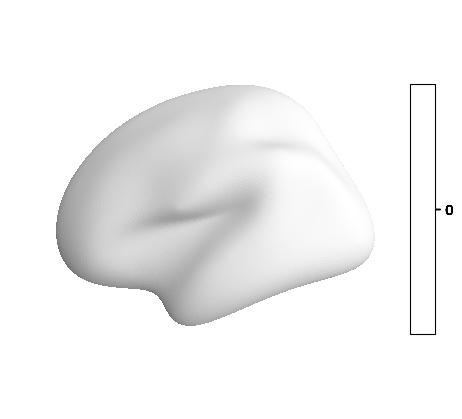

In [21]:

# Translate primary areas and association areas, take average and differences and plot on surface.
fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")
hemi = "left"
infl_mesh = fsaverage[f"infl_{hemi}"]
# Average voxels 5 mm close to the 3d pial surface

radius = 8
kind = 'ball'
depth=0.5
inter='linear'
n_samples=160
pial_mesh = fsaverage[f"pial_{hemi}"]
inner_mesh=fsaverage[f"white_{hemi}"]
pial_mesh = fsaverage[f"pial_{hemi}"]


# association - primary cortex
Xa = np.zeros(10242)
Xp = np.zeros(10242)

association_list = [ 
                    'Taenia tecta', 'Cortical amygdalar area', 'Piriform-amygdalar area', 'Subiculum', 
                    'Entorhinal area',  'Dorsal auditory area', 'Ventral auditory area', 'Secondary motor area', 
                    'Supplemental somatosensory area', 'Posterior parietal association areas',  
                    'Temporal association areas', 'Frontal pole, cerebral cortex', 'Orbital area']

primary_list = ['Primary motor area', 'Primary auditory area', 'Primary somatosensory area', 'Visual areas', 'Main olfactory bulb']


list1 = association_list
list2 = primary_list

for ROI in list1:
    img=translate_mouse_human(ROI)[0]
    radius=8
    Xa += surface.vol_to_surf(img,pial_mesh, radius=radius, interpolation='linear', kind='ball').T


for ROI in list2:
    img=translate_mouse_human(ROI)[0]
    radius=8
    Xp += surface.vol_to_surf(img,pial_mesh, radius=radius, interpolation='linear', kind='ball').T


Xa = Xa / len(list1)
Xp = Xp / len(list2)
X = np.nan_to_num(Xp - Xa)

display1 = plotting.plot_surf(
    infl_mesh,
    X,
    view=("lateral"),
    cmap='jet',
    colorbar=True,
    threshold=0,
    vmin=X.min(),
    vmax=X.max(),
    bg_map=fsaverage[f"sulc_{hemi}"], 
)
# display1.savefig('display1.png')

display2 = plotting.plot_surf(
infl_mesh,
X,
view=("medial"),
cmap='jet',
colorbar=False,
threshold=0,
vmin=X.min(),
vmax=X.max(),
bg_map=fsaverage[f"sulc_{hemi}"],
)
# display2.savefig('display2.png')



# images = [Image.open(x) for x in ['display1.png', 'display2.png']]
# widths, heights = zip(*(i.size for i in images))

# total_width = sum(widths)
# max_height = max(heights)

# new_im = Image.new('RGB', (total_width, max_height))

# x_offset = 0
# for im in images:
#   new_im.paste(im, (x_offset,0))
#   x_offset += im.size[0]

#new_im.save('../primary_vs_association_cortical_similarity_difference.png')



In [ ]:
plotting.plot_surf(
    infl_mesh,
    Xa,
    view=("lateral"),
    cmap='jet',
    colorbar=True,
    threshold=0,
    vmin=X.min(),
    vmax=X.max(),
    bg_map=fsaverage[f"sulc_{hemi}"], 
)

In [20]:
arr = np.nan_to_num(Xp-Xa)

In [26]:
Xa.min()

nan